# Analysing E Commerce Dataset

The dataset is made public by Olist , the largest department store in Brazil . There are multiple datasets consisting of customer transaction details . The dataset provides a great opportunity to let us explore in different angles like 

* What is the average transaction value ?
* Most bought customer categories 
* Trend of sales over the day,week,month
* Number of products boight by each customer
* Delivery days ...


In [3]:
## Loading the required libraries:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import datetime as dt
import calendar
from scipy.stats import skew,kurtosis

import warnings
warnings.filterwarnings('ignore')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
## Reading the datas:
order = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/E-commerce Store Data Analysis/Brazilian E-Commerce Public Dataset by Olist/olist_orders_dataset.csv")  ## Unclassified orders dataset
order_items = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/E-commerce Store Data Analysis/Brazilian E-Commerce Public Dataset by Olist/olist_order_items_dataset.csv")  ## Unclassified orders dataset
order_reviews = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/E-commerce Store Data Analysis/Brazilian E-Commerce Public Dataset by Olist/olist_order_reviews_dataset.csv")  ## Unclassified orders dataset
customer=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/E-commerce Store Data Analysis/Brazilian E-Commerce Public Dataset by Olist/olist_customers_dataset.csv")  ### Unique customer id 
payment =pd.read_csv("/content/drive/MyDrive/Colab Notebooks/E-commerce Store Data Analysis/Brazilian E-Commerce Public Dataset by Olist/olist_order_payments_dataset.csv")  ### Payment dataset
product = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/E-commerce Store Data Analysis/Brazilian E-Commerce Public Dataset by Olist/product_category_name_translation.csv")  ## Product translation to english
geo=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/E-commerce Store Data Analysis/Brazilian E-Commerce Public Dataset by Olist/olist_geolocation_dataset.csv")  ## Location data
product_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/E-commerce Store Data Analysis/Brazilian E-Commerce Public Dataset by Olist/olist_products_dataset.csv")  ## Product translation to english
sellers=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/E-commerce Store Data Analysis/Brazilian E-Commerce Public Dataset by Olist/olist_sellers_dataset.csv") ## Seller information

In [23]:
order_items.shape

(112650, 7)

In [9]:
order.shape

(99441, 8)

In [6]:
order_reviews.shape

(99224, 7)

In [6]:
payment.shape

(103886, 5)

In [5]:
customer.shape

(99441, 5)

In [7]:
product.shape

(71, 2)

In [8]:
geo.shape

(1000163, 5)

In [7]:
sellers.shape

(3095, 4)

### Order Summary:

In [8]:
print("Total number of orders in the database:",order['order_id'].nunique())
print("Total Number of customers:",order['customer_id'].nunique())

Total number of orders in the database: 99441
Total Number of customers: 99441


Lets check the order status

In [9]:
status=order.groupby('order_status')['order_id'].nunique().sort_values(ascending=False)

In [10]:
status

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_id, dtype: int64

A majority of the orders in the database are delivered products , while some are in transit .

### Order Value :

Lets take a look at the order value column . We see that there are no currency value specified and we assume that it is in local currency unit -BRL . 

In [11]:
order = order.merge(order_items[['order_id','product_id','price','freight_value']], on =['order_id'] )

In [12]:
## Executive Summary:
print("Maximum order amount is BRL:",order['price'].max())
print("Minumum order amount is BRL:",order['price'].min())
print("Average order value is BRL:",order['price'].mean())
print("Median order value is BRL:",order['price'].median())

Maximum order amount is BRL: 6735.0
Minumum order amount is BRL: 0.85
Average order value is BRL: 120.65373901477244
Median order value is BRL: 74.99


We summarise the order with the help of order id and have a look at the order value and freight value .

In [13]:
value = order.groupby('order_id')['price','freight_value'].sum().sort_values(by='price',ascending=False).reset_index()

The top 5 orders and their value is shown below:

In [14]:
value.head()

,order_id,price,freight_value
0,03caa2c082116e1d31e67e9ae3700499,13440.0,224.08
1,736e1922ae60d0d6a89247b851902527,7160.0,114.88
2,0812eb902a67711a1cb742b3cdaa65ae,6735.0,194.31
3,fefacc66af859508bf1a7934eab1e97f,6729.0,193.21
4,f5136e38d1a14a4dbd87dff67da82701,6499.0,227.66


In [15]:
## Executive Summary:
print("Maximum order amount is BRL:",value['price'].max())
print("Minumum order amount is BRL:",value['price'].min())
print("Average order value is BRL:",value['price'].mean())
print("Median order value is BRL:",value['price'].median())

Maximum order amount is BRL: 13440.0
Minumum order amount is BRL: 0.85
Average order value is BRL: 137.75407637907608
Median order value is BRL: 86.9


Lets plot a histogram of the product value and freight value to understand the skewness of the data.

Text(0, 0.5, 'Frequency')

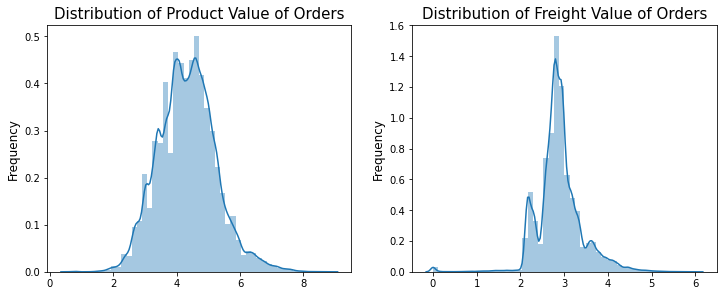

In [16]:
plt.figure(figsize=(12,10))

plt.subplot(221)
g = sns.distplot(np.log(order['price'] + 1))
g.set_title("Distribution of Product Value of Orders", fontsize=15)
g.set_xlabel("")
g.set_ylabel("Frequency", fontsize=12)

plt.subplot(222)
g1 = sns.distplot(np.log(order['freight_value'] + 1))
g1.set_title("Distribution of Freight Value of Orders", fontsize=15)
g1.set_xlabel("")
g1.set_ylabel("Frequency", fontsize=12)


Both the distributions seems to follow a normal curve.Lets check the skewness and kurtosis.

In [17]:
print("Skewness of the transaction value:",skew(np.log(order['price']+1)))
print("Excess Kurtosis of the transaction value:",kurtosis(np.log(order['price']+1)))

Skewness of the transaction value: 0.29352507587395954
Excess Kurtosis of the transaction value: 0.4455250272108402


Skewness of the data suggests that the data is fairly symmetrical and positive whereas kurtosis value is  < 3.

### Number of products people usually order:

In [18]:
order_usual=order.groupby('order_id')['order_id'].aggregate('count').reset_index(level=0, drop=True).reset_index()
order_usual=order_usual['order_id'].value_counts()
order_usual.head()

1    88863
2     7516
3     1322
4      505
5      204
Name: order_id, dtype: int64

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '20'),
 Text(0, 0, '21')]

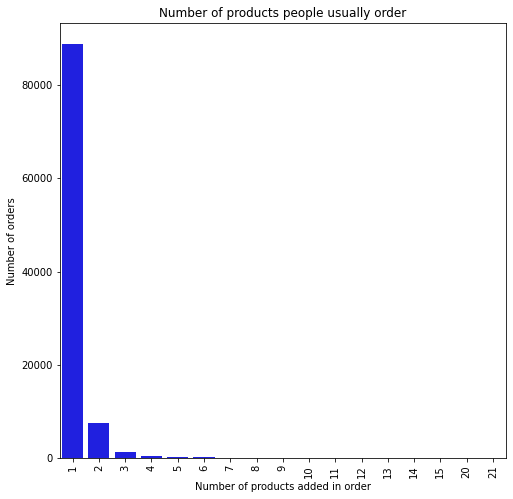

In [23]:
plt.figure(figsize=(8,8))
ax=sns.barplot(x=order_usual.index,y=order_usual.values,color="blue")
ax.set_xlabel("Number of products added in order")
ax.set_ylabel("Number of orders")
ax.set_title("Number of products people usually order")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

Most of them have ordered only 1 product.The number of people ordering more than 2 items is very less.

### Most Bought product categories:

In [24]:
product = product_data.merge(product, on = ['product_category_name'] )

In [25]:
order = order.merge(product[['product_category_name_english','product_id']],on=['product_id'])

In [26]:
most_product=order.groupby('product_category_name_english').aggregate({'order_id':'count'}).rename(columns={'order_id':'order_count'}).sort_values(by='order_count',ascending=False).reset_index()
most_product.head()

,product_category_name_english,order_count
0,bed_bath_table,11115
1,health_beauty,9670
2,sports_leisure,8641
3,furniture_decor,8334
4,computers_accessories,7827


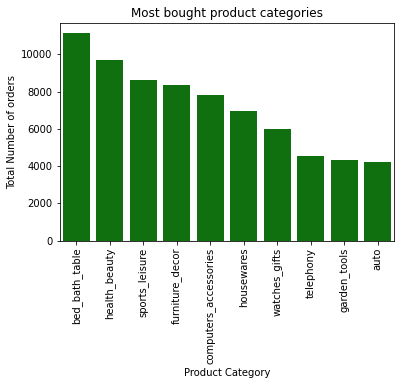

In [27]:
### Visualising top 10 most bought product categories:
sns.barplot(x='product_category_name_english',y='order_count',data=most_product[:10],color="green")
plt.xlabel("Product Category")
plt.ylabel("Total Number of orders")
plt.title("Most bought product categories")
plt.xticks(rotation='vertical')
plt.show()

Bed Bath table,health beauty,sports are some categories that are bought most often by the customers.The difference in order count between bed bath table and health beauty is high.

### Order Trend:

In [28]:
order['order_purchase_timestamp']=pd.to_datetime(order['order_purchase_timestamp'])
order['order_delivered_customer_date']=pd.to_datetime(order['order_delivered_customer_date'])

In [29]:
## Create new columns for date,day,time,month:
order['weekday']=order['order_purchase_timestamp'].dt.day_name()
order['year']=order['order_purchase_timestamp'].dt.year
order['monthday']=order['order_purchase_timestamp'].dt.day
order['weekday'] = order['order_purchase_timestamp'].dt.weekday
order['month']=order['order_purchase_timestamp'].dt.month
order['hour']=order['order_purchase_timestamp'].dt.hour

Text(0.5, 1.0, 'Transaction Value by Year')

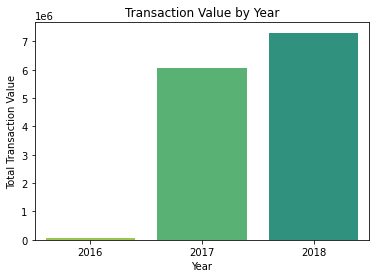

In [30]:
# Trend by Year:
trend_year=pd.DataFrame(order.groupby('year')['price'].sum().sort_values(ascending=False)).reset_index()
ax=sns.barplot(x='year',y='price',data=trend_year,palette=sns.set_palette(palette='viridis_r'))
#ax.ticklabel_format()
ax.set_xlabel('Year')
ax.set_ylabel('Total Transaction Value')
ax.set_title('Transaction Value by Year')

The data is available from Sept 2016 to Sept 2018 . Therefore we see a very low sales for the year 2016 .Entire year data is available for 2017 and hence that year is on the higher side whereas sales till Sept for 2018 is plotted.For lack of entire data,we are unable to conclude any significant findings here.

Text(0.5, 1.0, 'Box Plot of transactions over the year')

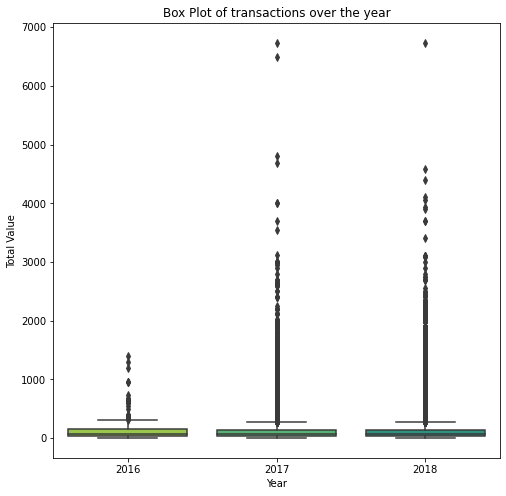

In [30]:
## Boxplot for transactions by year:
plt.figure(figsize=(8,8))
ax=sns.boxplot(x='year',y='price',data=order,palette=sns.set_palette(palette='viridis_r'))
ax.set_xlabel('Year')
ax.set_ylabel('Total Value')
ax.set_title('Box Plot of transactions over the year')

We find that most of the transaction fall below BRL 2000 . There are more outliers for the year 2017 ( since there is complete one year data for this).The maximum transaction value has been 14000 . 

### Average value of transactions per month:

Text(0, 0.5, 'Value')

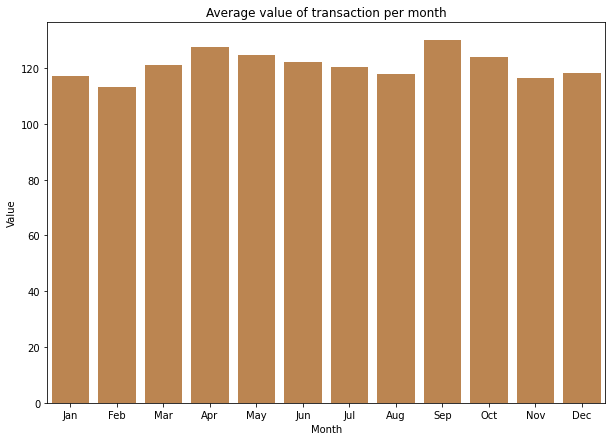

In [32]:
trend_month=pd.DataFrame(order.groupby('month').agg({'price':'mean'}).rename(columns={'price':'mean_transaction'})).reset_index()
x1 = trend_month.month.tolist()
y1 = trend_month.mean_transaction.tolist()
mapp = {}
for m,v in zip(x1, y1):
    mapp[m] = v
xn = [calendar.month_abbr[int(x)] for x in sorted(x1)]
vn = [mapp[x] for x in sorted(x1)]

plt.figure(figsize=(10,7))
ax=sns.barplot(x=xn,y=vn, color='peru')
ax.set_title("Average value of transaction per month")
ax.set_xlabel('Month')
ax.set_ylabel('Value')

The average value of transaction is high during the month of October and September.

### Average value of transaction by day of the week:

In [33]:
trend_weekday=pd.DataFrame(order.groupby('weekday').agg({'price':'mean'}).rename(columns={'price':'Mean_Transaction'})).reset_index()

Text(0, 0.5, 'Value')

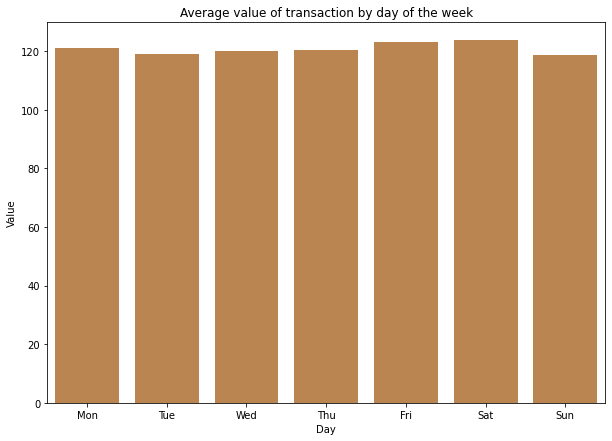

In [34]:
x2 = trend_weekday.index.tolist()
y2 = trend_weekday.Mean_Transaction.tolist()

weekmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
x2 = [weekmap[x] for x in x2]
wkmp = {}
for j,x in enumerate(x2):
    wkmp[x] = y2[j]
order_week = list(weekmap.values())
ordervals = [wkmp[val] for val in order_week]

plt.figure(figsize=(10,7))
ax=sns.barplot(x=order_week,y=ordervals, color='peru')
ax.set_title("Average value of transaction by day of the week")
ax.set_xlabel('Day')
ax.set_ylabel('Value')

There seems to be not much trend observed during the day of the transaction . Lets check the frequency of the orders.

In [35]:
freq_weekday=pd.DataFrame(order.groupby('weekday').agg({'order_id':'count'}).rename(columns={'order_id':'order_count'})).reset_index()

Text(0, 0.5, 'Value')

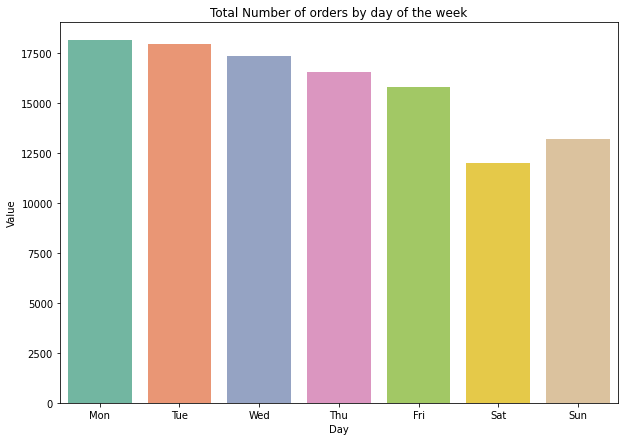

In [36]:
x3 = freq_weekday.index.tolist()
y3 = freq_weekday.order_count.tolist()

weekmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
x3 = [weekmap[x] for x in x3]
wkmp = {}
for j,x in enumerate(x3):
    wkmp[x] = y3[j]
order_week = list(weekmap.values())
ordervals = [wkmp[val] for val in order_week]

plt.figure(figsize=(10,7))
ax=sns.barplot(x=order_week,y=ordervals, palette=sns.color_palette(palette="Set2"))
ax.set_title("Total Number of orders by day of the week")
ax.set_xlabel('Day')
ax.set_ylabel('Value')

The frequency of the orders has been higher on Mon,Tue whereas the freq of orders is low during Saturday and sundays.This means that during weekend people are not interested in online shopping going only by the frequency of the orders but combining this with the average value of transactions during the day there is a relatively high average value of transaction happening during saturdays compared to other days.

In [37]:
week=pd.merge(trend_weekday,freq_weekday,on='weekday',how='inner')

In [38]:
# plt.figure(figsize=(8,8))
# sns.jointplot(x='Mean_Transaction', y='order_count',data=week, size=10,color='red')
# plt.ylabel('Order Count', fontsize=12)
# plt.xlabel('Average value of transaction', fontsize=12)
# plt.show()

### Order Trend by hour :

In [40]:
trend_hour=order.groupby('hour').agg({'order_id':'count'}).rename(columns={'order_id':'freq_order'}).reset_index()

Text(0.5, 1.0, 'Frequency of transaction over the hour')

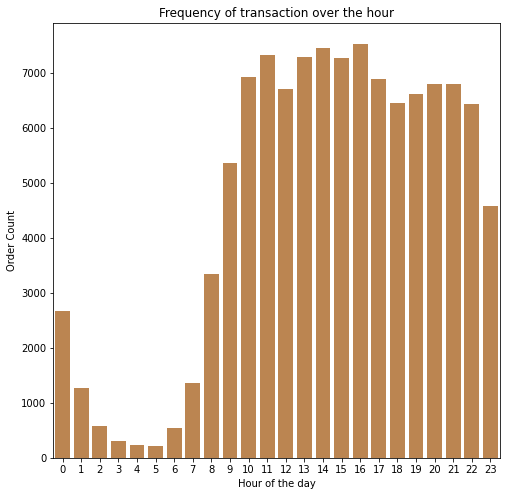

In [41]:
plt.figure(figsize=(8,8))
ax=sns.barplot(x=trend_hour['hour'],y=trend_hour['freq_order'],color="peru")
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Order Count')
ax.set_title("Frequency of transaction over the hour")

From the plot we see that the frequency of the order steadly rises as the day progresses and reaches the peak after noon and continues till 22 hrs . There is a dip in the transaction during evening time between 18-19 hrs and it sees a rise after that . 

### Frequency of orders during the hour over the day:

In [48]:
day_hour=order.groupby(['weekday','hour']).agg({'order_id':'count'}).rename(columns={'order_id':'freq'}).reset_index()

In [49]:
day_hour.weekday=day_hour.weekday.map(weekmap)
day_hour.head()

,weekday,hour,freq
0,Mon,0,365
1,Mon,1,144
2,Mon,2,73
3,Mon,3,46
4,Mon,4,23


In [50]:
### Sorting it so that the plot order is correct.
day_hour['weekday']=pd.Categorical(day_hour['weekday'],categories=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'],ordered=True)

In [52]:
day_hour=day_hour.pivot('weekday','hour','freq')

In [53]:
day_hour

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,,,,
Sun,299,155,87,47,31,26,34,116,228,378,602,775,751,795,760,791,785,881,1005,1002,1059,951,969,686
Mon,365,144,73,46,23,23,72,177,546,855,1141,1209,1091,1131,1268,1244,1248,1122,1041,1064,1126,1219,1110,803
Tue,331,170,92,36,28,27,73,242,577,979,1101,1186,1000,1204,1282,1172,1247,1106,1021,1006,1071,1144,1093,778
Wed,461,192,93,39,36,30,100,237,565,957,1169,1177,1053,1129,1216,1109,1163,1081,943,926,996,1053,951,667
Thu,403,194,83,38,46,30,90,248,581,862,1117,1085,1088,1132,1093,1050,1216,1005,864,909,947,929,948,599
Fri,476,227,75,54,47,40,105,221,570,858,1078,1118,964,1121,1074,1122,1128,921,807,862,812,792,764,581
Sat,338,185,71,49,30,31,74,116,273,469,722,776,766,785,758,788,750,786,767,858,792,722,609,471


Text(0.5, 1.0, 'Heatmap of tranactions over the hour by day')

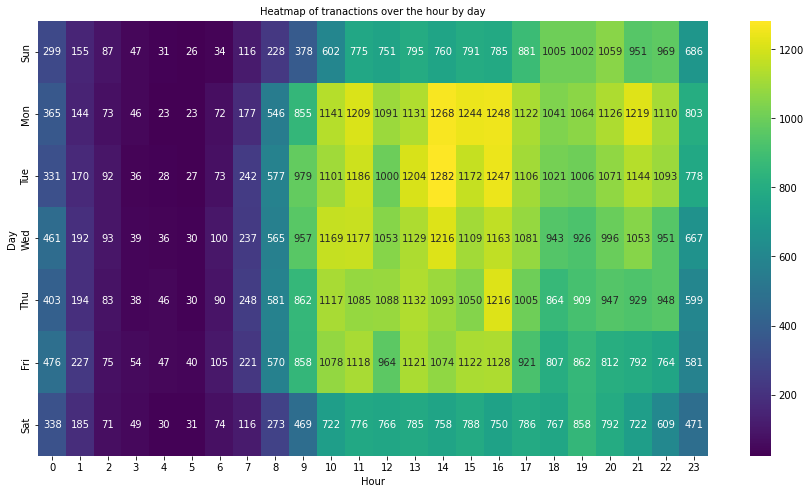

In [54]:
plt.figure(figsize=(15,8))
ax=sns.heatmap(day_hour,annot=True,fmt="d",cmap="viridis")
ax.set_xlabel("Hour")
ax.set_ylabel("Day")
ax.set_title("Heatmap of tranactions over the hour by day",size=10)

* As the day progresses,the number of orders placed increases . 
* There is clearly a difference in the order frequency between weekdays and weekends . 
* While during weekdays , the order frequency increases steadly after 9 AM , the order frequency picks up only after 15:00 hrs during sundays . 

### City.State and Transaction Value :

In [55]:
order = order.merge(customer[['customer_id','customer_city','customer_state']], on = 'customer_id')

In [56]:
trans_state=pd.DataFrame(order.groupby('customer_state').agg({'price':'mean'}).rename(columns={'price':'avg_trans'}).sort_values(by='avg_trans',ascending=False)).reset_index()

Text(0.5, 1.0, 'Average Transaction Value for each state')

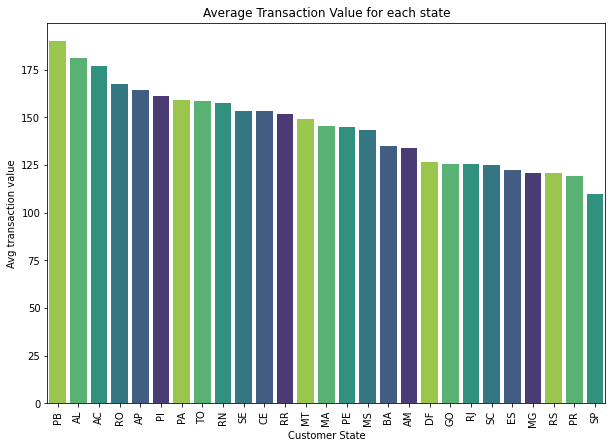

In [57]:
plt.figure(figsize=(10,7))
ax=sns.barplot(x='customer_state',y='avg_trans',data=trans_state,palette=sns.color_palette(palette="viridis_r"))
ax.set_xlabel('Customer State')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel('Avg transaction value')
ax.set_title("Average Transaction Value for each state")

States Acre,Rondonia,Alagoas have a higher transaction value whereas Sao Paulo ,Minas Gerias have the lowest average transaction.

In [58]:
### By City :
trans_city=pd.DataFrame(order.groupby('customer_city').agg({'price':'mean'}).rename(columns={'price':'avg_trans'}).sort_values(by='avg_trans',ascending=False)).reset_index()

In [59]:
trans_city[:10]

,customer_city,avg_trans
0,pianco,2200.00
1,nova esperanca do piria,2199.00
2,engenheiro navarro,1997.00
3,sape,1850.00
4,mariental,1799.00
5,loreto,1599.99
6,ibitita,1450.00
7,bonfinopolis de minas,1359.90
8,pirpirituba,1340.00
9,barao ataliba nogueira,1300.00


Text(0.5, 1.0, 'Top 10 - Average Transaction Value for each City')

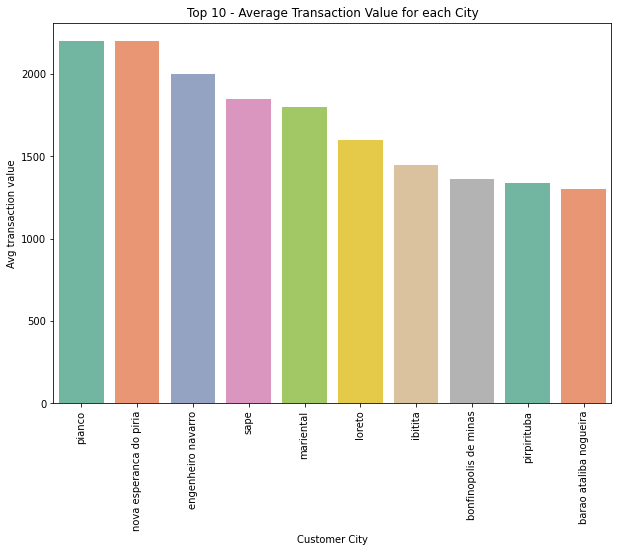

In [60]:
plt.figure(figsize=(10,7))
ax=sns.barplot(x='customer_city',y='avg_trans',data=trans_city[:10],palette=sns.color_palette(palette="Set2"))
ax.set_xlabel('Customer City')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel('Avg transaction value')
ax.set_title("Top 10 - Average Transaction Value for each City")

### Order Delivery :

Lets check the average number of days between order and delivery.

In [61]:
order['day_to_delivery']=(order['order_delivered_customer_date']-order['order_purchase_timestamp']).dt.days

In [62]:
print("Average days to delivery {}".format(np.round(order['day_to_delivery'].mean(),0)))

Average days to delivery 12.0


Lets check the overall scenario.

In [67]:
order

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,price,freight_value,product_category_name_english,weekday,year,monthday,month,hour,customer_city,customer_state,day_to_delivery
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,29.99,8.72,housewares,0,2017,2,10,10,sao paulo,SP,8.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,87285b34884572647811a353c7ac498a,29.99,7.78,housewares,1,2017,15,8,18,sao paulo,SP,2.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,87285b34884572647811a353c7ac498a,29.99,7.78,housewares,2,2017,2,8,18,sao paulo,SP,5.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,87285b34884572647811a353c7ac498a,29.99,14.10,housewares,0,2017,23,10,23,florianopolis,SC,14.0
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumery,1,2018,24,7,20,barreiras,BA,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111018,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-18 16:42:51,2017-08-23 15:36:29,2017-08-31 00:00:00,0df37da38a30a713453b03053d60d3f7,356.00,18.12,sports_leisure,3,2017,10,8,21,sao paulo,SP,12.0
111019,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-18 16:42:51,2017-08-23 15:36:29,2017-08-31 00:00:00,0df37da38a30a713453b03053d60d3f7,356.00,18.12,sports_leisure,3,2017,10,8,21,sao paulo,SP,12.0
111020,cfa78b997e329a5295b4ee6972c02979,a2f7428f0cafbc8e59f20e1444b67315,delivered,2017-12-20 09:52:41,2017-12-20 10:09:52,2017-12-20 20:25:25,2018-01-26 15:45:14,2018-01-18 00:00:00,3d2c44374ee42b3003a470f3e937a2ea,55.90,15.14,musical_instruments,2,2017,20,12,9,campo do tenente,PR,37.0
111021,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,ac35486adb7b02598c182c2ff2e05254,72.00,13.08,health_beauty,3,2017,9,3,9,sao jose dos campos,SP,8.0


In [68]:
delivery=order.groupby('day_to_delivery')['order_id'].aggregate({'order_id':'count'}).rename(columns={'order_id':'freq'}).reset_index().dropna()
delivery['freq']=delivery['freq'].astype(int)

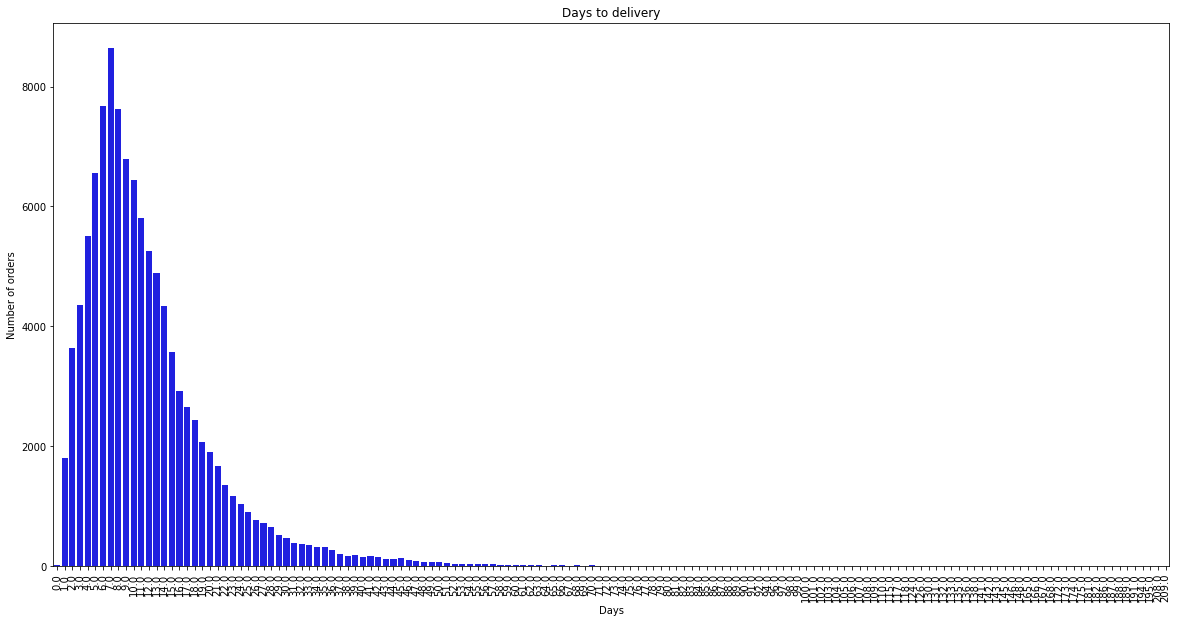

In [69]:
plt.figure(figsize=(20,10))
sns.barplot(x='day_to_delivery',y='freq',data=delivery,color="blue")
plt.title("Days to delivery")
plt.xlabel("Days")
plt.xticks(rotation="vertical")
plt.ylabel("Number of orders")
plt.show()

A majority of the orders are getting delivered within a week whereas there were few orders that is taking over 1.5 months too .

### Payments :

Lets check the mode of payments used for transaction

In [70]:
pay_type=payment.groupby('payment_type').aggregate({'order_id':'count'}).rename(columns={'order_id':'count'}).sort_values(by='count',ascending=False).reset_index()

Text(0, 0.5, 'Number of instances')

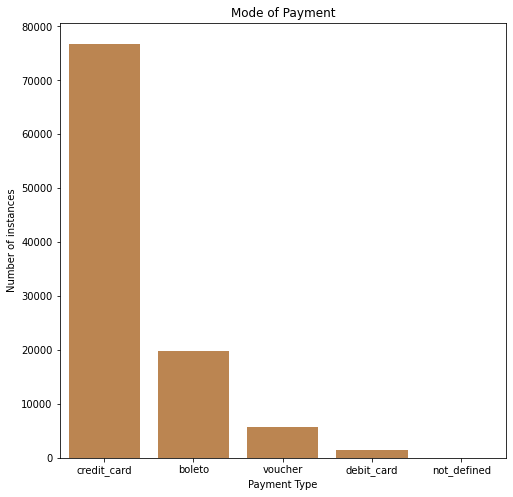

In [71]:
pay_type['perc']=np.round((pay_type['count']/pay_type['count'].sum())*100,2)

plt.figure(figsize=(8,8))
ax=sns.barplot(x='payment_type',y='count',data=pay_type,color='peru')
plt.title("Mode of Payment")
plt.xlabel('Payment Type')
plt.ylabel('Number of instances')

A large number of online buyers use credit card their prefered mode of payment followed by boleto.According to [wiki](https://en.wikipedia.org/wiki/Boleto) ,boleto is a  a payment method in Brazil regulated by FEBRABAN, short for Brazilian Federation of Banks.A boleto can be paid at ATMs, branch facilities and internet banking of any Bank, Post Office, Lottery Agent and some supermarkets until its due date. After the due date it can only be paid at the issuer bank facilities.

Lets check the average value of transaction used for each type of payment.

In [62]:
print("Average value of transaction on credit card : BRL {:,.0f}".format(np.mean(payment[payment.payment_type=='credit_card']['payment_value'])))
print("Average value of transaction on boleto : BRL {:,.0f}".format(np.mean(payment[payment.payment_type=='boleto']['payment_value'])))
print("Average value of transaction on voucher: BRL {:,.0f}".format(np.mean(payment[payment.payment_type=='voucher']['payment_value'])))
print("Average value of transaction on debit card: BRL {:,.0f}".format(np.mean(payment[payment.payment_type=='debit_card']['payment_value'])))

Average value of transaction on credit card : BRL 163
Average value of transaction on boleto : BRL 145
Average value of transaction on voucher: BRL 66
Average value of transaction on debit card: BRL 143


For each of the transaction types , the value at the quantiles is printed out for better interpretation . Distribution and box plot is also tried out for visualisation purpose.

In [63]:
print("Credit Card quantiles")
print(payment[payment.payment_type=='credit_card']['payment_value'].quantile([.01,.25,.5,.75,.99]))
print("")
print("Boleto quantiles")
print(payment[payment.payment_type=='boleto']['payment_value'].quantile([.01,.25,.5,.75,.99]))
print("")
print("Voucher quantiles")
print(payment[payment.payment_type=='voucher']['payment_value'].quantile([.01,.25,.5,.75,.99]))
print("")
print("Debit Card quantiles")
print(payment[payment.payment_type=='debit_card']['payment_value'].quantile([.01,.25,.5,.75,.99]))

Credit Card quantiles
0.01      13.4100
0.25      62.2100
0.50     106.8700
0.75     181.2100
0.99    1097.3334
Name: payment_value, dtype: float64

Boleto quantiles
0.01     21.7500
0.25     55.5225
0.50     93.8900
0.75    160.7625
0.99    946.9896
Name: payment_value, dtype: float64

Voucher quantiles
0.01      0.7170
0.25     18.0350
0.50     39.2800
0.75     80.0000
0.99    454.5824
Name: payment_value, dtype: float64

Debit Card quantiles
0.01     20.7412
0.25     51.1000
0.50     89.3000
0.75    154.3200
0.99    941.1528
Name: payment_value, dtype: float64


For transactions greater than BRL 100 , people use debit card,boleto or credit card . For transaction of higher value , people have used credit mode of payment followed by bolero and then debit card . The preference of using vouchers for transaction is on the lower side .Lets check the distribution of the transactions.

[Text(0, 0, 'credit_card'),
 Text(0, 0, 'boleto'),
 Text(0, 0, 'voucher'),
 Text(0, 0, 'debit_card'),
 Text(0, 0, 'not_defined')]

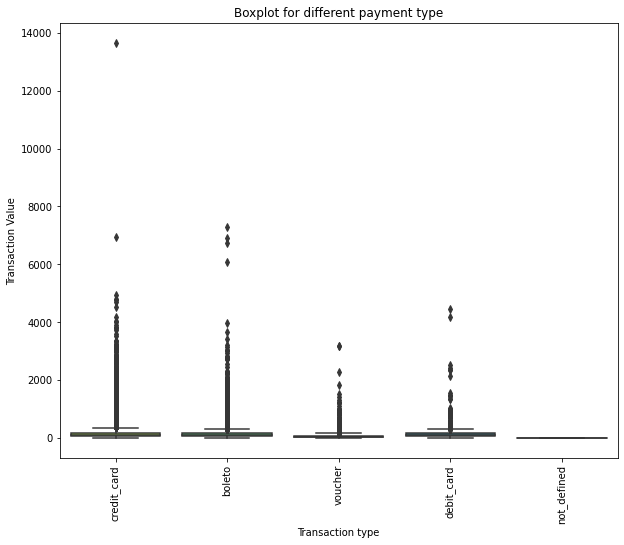

In [65]:
plt.figure(figsize=(10,8))
ax=sns.boxplot(x=payment.payment_type,y=payment.payment_value,palette=sns.color_palette(palette="viridis_r"))
ax.set_title("Boxplot for different payment type")
ax.set_xlabel("Transaction type")
ax.set_ylabel("Transaction Value")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)



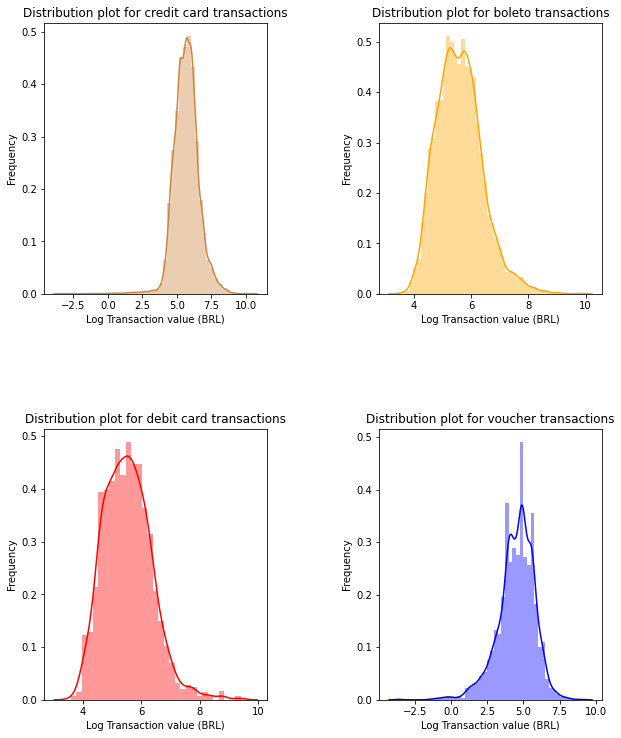

In [74]:
payment=payment[payment['payment_value']!=0]
plt.figure(figsize=(10,8))
plt.subplot(221)
ax=sns.distplot(np.log(payment[payment.payment_type=='credit_card']['payment_value'])+1,color="peru")
ax.set_xlabel("Log Transaction value (BRL)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution plot for credit card transactions")
plt.subplot(222)
ax1=sns.distplot(np.log(payment[payment.payment_type=='boleto']['payment_value'])+1,color="orange")
ax1.set_xlabel("Log Transaction value (BRL)")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution plot for boleto transactions")
plt.subplot(223)
ax2=sns.distplot(np.log(payment[payment.payment_type=='debit_card']['payment_value'])+1,color="red")
ax2.set_xlabel("Log Transaction value (BRL)")
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution plot for debit card transactions")
plt.subplot(224)
ax3=sns.distplot(np.log(payment[payment.payment_type=='voucher']['payment_value'])+1,color="blue")
ax3.set_xlabel("Log Transaction value (BRL)")
ax3.set_ylabel("Frequency")
ax3.set_title("Distribution plot for voucher transactions")


plt.subplots_adjust(wspace = 0.5, hspace = 0.5,
                    top = 1.3)

plt.show()

From the distribution & box plot we understand the following

The distribution for credit card type of transaction is nearly normal and from the boxplot it is seen that there are extreme outliers in this case.This means that for higher value of transactions ,people prefer to buy on credit and pay later.
Transaction through boleto is multimodal and seems to be for lesser value of BRL and here too the transactions are dominated by outliers.There seems to be a significant difference between credit card and boleto type of transactions .
Debit card and vouchers are not used much and there are two modes dominating the distribution plot .

### Analysis on Sellers:

In [75]:
order = order.merge(order_items[['order_id','seller_id']], on = 'order_id')

In [76]:
### Joining with the transaction data:
order_pay=pd.merge(order,sellers,how='left',on=['seller_id'])
order_pay.shape

(155029, 24)

#### Sellers who have sold most number of products:

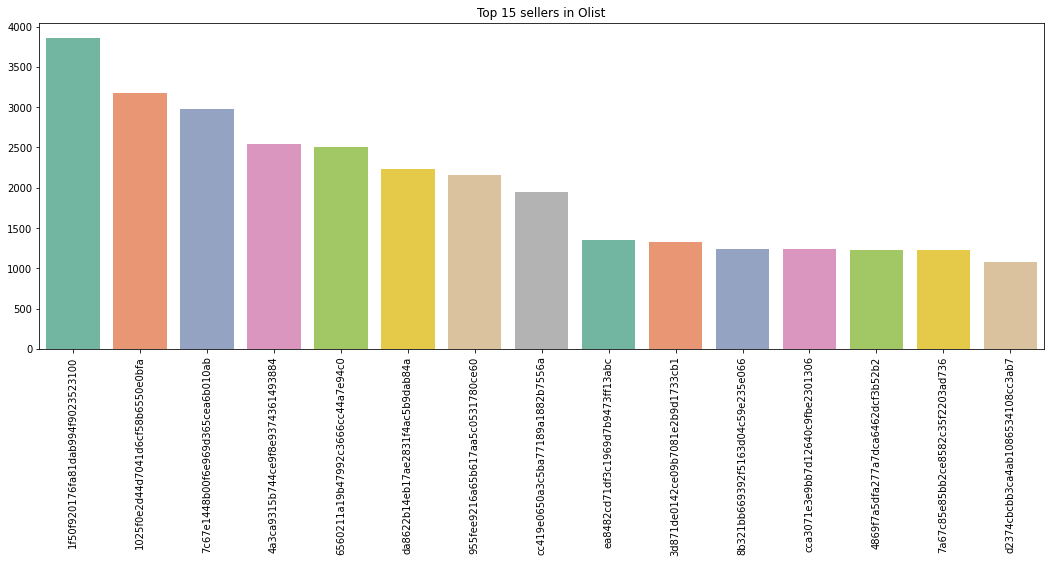

In [80]:
plt.figure(figsize=(18,6))
ax=sns.barplot(order_pay['seller_id'].value_counts()[:15].index,order_pay['seller_id'].value_counts()[:15].values,palette='Set2')
ax.set_title('Top 15 sellers in Olist')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

Lets see the top 3 products sold by each of these sellers.


In [77]:
top_15=order_pay.groupby('seller_id').apply(lambda x:x['product_category_name_english'].unique()).to_frame().reset_index()
top_15.columns=['seller_id','products']
top_15['product_count']=[len(c) for c in top_15['products']]
top_15.sort_values(by='product_count',ascending=False,inplace=True)

In [78]:
top_15.head(15)

,seller_id,products,product_count
2105,b2ba3715d723d245138f291a6fe42594,"[toys, cool_stuff, electronics, audio, station...",29
1789,955fee9216a65b617aa5c0531780ce60,"[garden_tools, furniture_decor, housewares, co...",24
932,4e922959ae960d389249c378d1c939f5,"[cds_dvds_musicals, telephony, computers_acces...",23
2949,f8db351d8c4c4c22c6835c19a46f01b0,"[sports_leisure, cool_stuff, housewares, compu...",21
345,1da3aeb70d7989d1e6d9b0e887f97c23,"[computers_accessories, auto, sports_leisure, ...",21
286,18a349e75d307f4b4cc646a691ed4216,"[construction_tools_safety, fixed_telephony, c...",19
1347,70a12e78e608ac31179aea7f8422044b,"[telephony, consoles_games, computers_accessor...",16
1328,6edacfd9f9074789dad6d62ba7950b9c,"[housewares, auto, furniture_decor, market_pla...",16
1673,8b28d096634035667e8263d57ba3368c,"[watches_gifts, furniture_decor, housewares, h...",15
1193,634964b17796e64304cadf1ad3050fb7,"[computers_accessories, auto, watches_gifts, g...",15


There are 21 products sold by one seller.Overall the top 15 sellers by product count have 13 to 21 products in their portfolio.

### Summary :
The following are some of the key points noted from the Olist E commerce analysis.

* Maximum order amount is BRL 13440 and Minumum order amount is BRL 2.
* Most of the time,the number of products ordered has always been < 3 .Bed Bath table,health beauty,sports are some categories that are bought most often by the customers.
* The frequency of the orders has been higher on Mon,Tue whereas the frequency of orders is low during Saturday and sundays.
* In a day,the number of transactions happening rises after 11 and continues till 22:00 Hrs.
* Average time taken for delivery is a week and maximum has gone up to 1.5 months.
* Credit card,boleto have been used for transactions of high value whereas people prefer using vouchers for low transaction values.
* The anonymised seller data tells that the top 15 sellers with maximum portfolio of products have 13 to 21 products in their category .